<a href="https://colab.research.google.com/github/GianmarcoLuchetti/Bioavailability/blob/main/Bioavailability_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install rdkit -q
!pip3 install mordred -q
!pip3 install session_info -q

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import session_info

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem

seed = np.random.seed(5)

In [4]:
session_info.show()

In [9]:
df_train = pd.read_csv('/content/training_set.csv', dtype=object)

# Exploratory Data Analysis

## General Exploration

In [10]:
# visualize dataframe head
df_train.head()

,Unnamed: 0,SMILES,Bioavailability,Bioavailability_class,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,CCOC(=O)O[C@]1(C(=O)OCCl)CC[C@H]2[C@@H]3CCC4=C...,0,0,25.041640869364688,20.57281274082361,0.0,0.0,39.95664429799973,2.682353523552323,...,10.897128138837616,83.82474512124803,466.1758310120008,7.399616365269854,2580.0,68.0,180.0,227.0,12.32638888888889,6.979166666666665
1,1,Clc1ccc([C@H](Cn2ccnc2)OCc2csc3c(Cl)cccc23)c(C...,0,0,21.33917226222056,17.474154305386996,0.0,0.0,35.11677257057164,2.4378875382949183,...,10.17888193964875,77.81255531836474,435.9970671400004,10.380882550952391,1886.0,40.0,144.0,170.0,7.75,5.888888888888888
2,2,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,0,0,31.646473381404583,21.395324325699956,0.0,1.0,51.18687544142878,2.4460183697820717,...,10.537919225261291,90.65415317010971,580.1347322120008,8.789920185030315,6645.0,59.0,212.0,244.0,12.034722222222221,8.569444444444445
3,3,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,0,0,19.621501331170048,16.81140333016038,0.0,0.0,33.83174028004556,2.5791501076641987,...,10.369640025590375,73.4765216909693,344.1080262240005,8.193048243428583,1225.0,44.0,134.0,164.0,6.118055555555555,5.611111111111112
4,4,CCCCC(F)(F)[C@@]1(O)CC[C@H]2[C@@H](CC(=O)[C@@H...,0,0,20.387860451190146,16.59906230716484,1.0,0.0,32.77753950733269,2.5335162757395566,...,10.251570692406156,76.39818081779654,390.2217805640008,6.613928484135607,2140.0,42.0,136.0,158.0,10.930555555555557,6.020833333333332


In [11]:
# general info
print(f'Dataframe shape: {df_train.shape} \n')
print(f'Dataframe columns: {df_train.columns.to_list()}')

Dataframe shape: (1717, 1830) 

Dataframe columns: ['Unnamed: 0', 'SMILES', 'Bioavailability', 'Bioavailability_class', 'ABC', 'ABCGG', 'nAcid', 'nBase', 'SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A', 'SpMAD_A', 'LogEE_A', 'VE1_A', 'VE2_A', 'VE3_A', 'VR1_A', 'VR2_A', 'VR3_A', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nB', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'A

In [12]:
# number of distinct elements
df_train.nunique(axis=0)

Unnamed: 0               1717
SMILES                   1717
Bioavailability           144
Bioavailability_class       3
ABC                      1066
                         ... 
WPol                      107
Zagreb1                   143
Zagreb2                   283
mZagreb1                  650
mZagreb2                  771
Length: 1830, dtype: int64

In [13]:
# check for missing values
missing_values = df_train.isnull().sum()

# check for unexpected values (example: negative values in numeric columns)
numeric_columns = df_train.select_dtypes(include='number').columns
unexpected_values = df_train[numeric_columns].lt(0).sum()

# Combine results to identify invalid values
invalid_values_summary = pd.DataFrame({'Missing Values': missing_values, 'Unexpected Values': unexpected_values})
invalid_values_summary

,Missing Values,Unexpected Values
AATS0Z,0,NaN
AATS0are,0,NaN
AATS0d,0,NaN
AATS0dv,0,NaN
AATS0i,0,NaN
...,...,...
piPC5,0,NaN
piPC6,0,NaN
piPC7,0,NaN
piPC8,0,NaN


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Values']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Values'}, axis=1)
              .sort_values('Missing Values', ascending=True))
  xs = counted['Missing Values']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = invalid_values_summary.sort_values('Missing Values', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Values')
_ = plt.ylabel('count()')

In [14]:
# check NaN values
print(f'Not A Number values: {df_train.isna().sum().sum()}')

Not A Number values: 0


## Feature Selection

In [15]:
# computation of feature relevance using the random forest algorithm

X_train = np.array(df_train.iloc[:, 4:], dtype=float)
y_train = np.array(df_train['Bioavailability_class'])

feat_labels = df_train.columns[4:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) TopoPSA(NO)                    0.002555
 2) MID_O                          0.002510
 3) ATS4pe                         0.002440
 4) ATS4are                        0.002150
 5) GATS1se                        0.002071
 6) ATSC1pe                        0.001986
 7) AETA_eta                       0.001952
 8) TopoPSA                        0.001931
 9) ATS4p                          0.001919
10) RPCG                           0.001906
11) ATS5s                          0.001824
12) PEOE_VSA1                      0.001775
13) AATSC1pe                       0.001710
14) AMID_O                         0.001688
15) EState_VSA8                    0.001662
16) GATS2pe                        0.001659
17) ATS4i                          0.001645
18) AATSC1are                      0.001588
19) MATS1are                       0.001564
20) MDEO-12                        0.001563
21) SLogP                          0.001554
22) SMR_VSA1                       0.001546
23) GATS2m                      

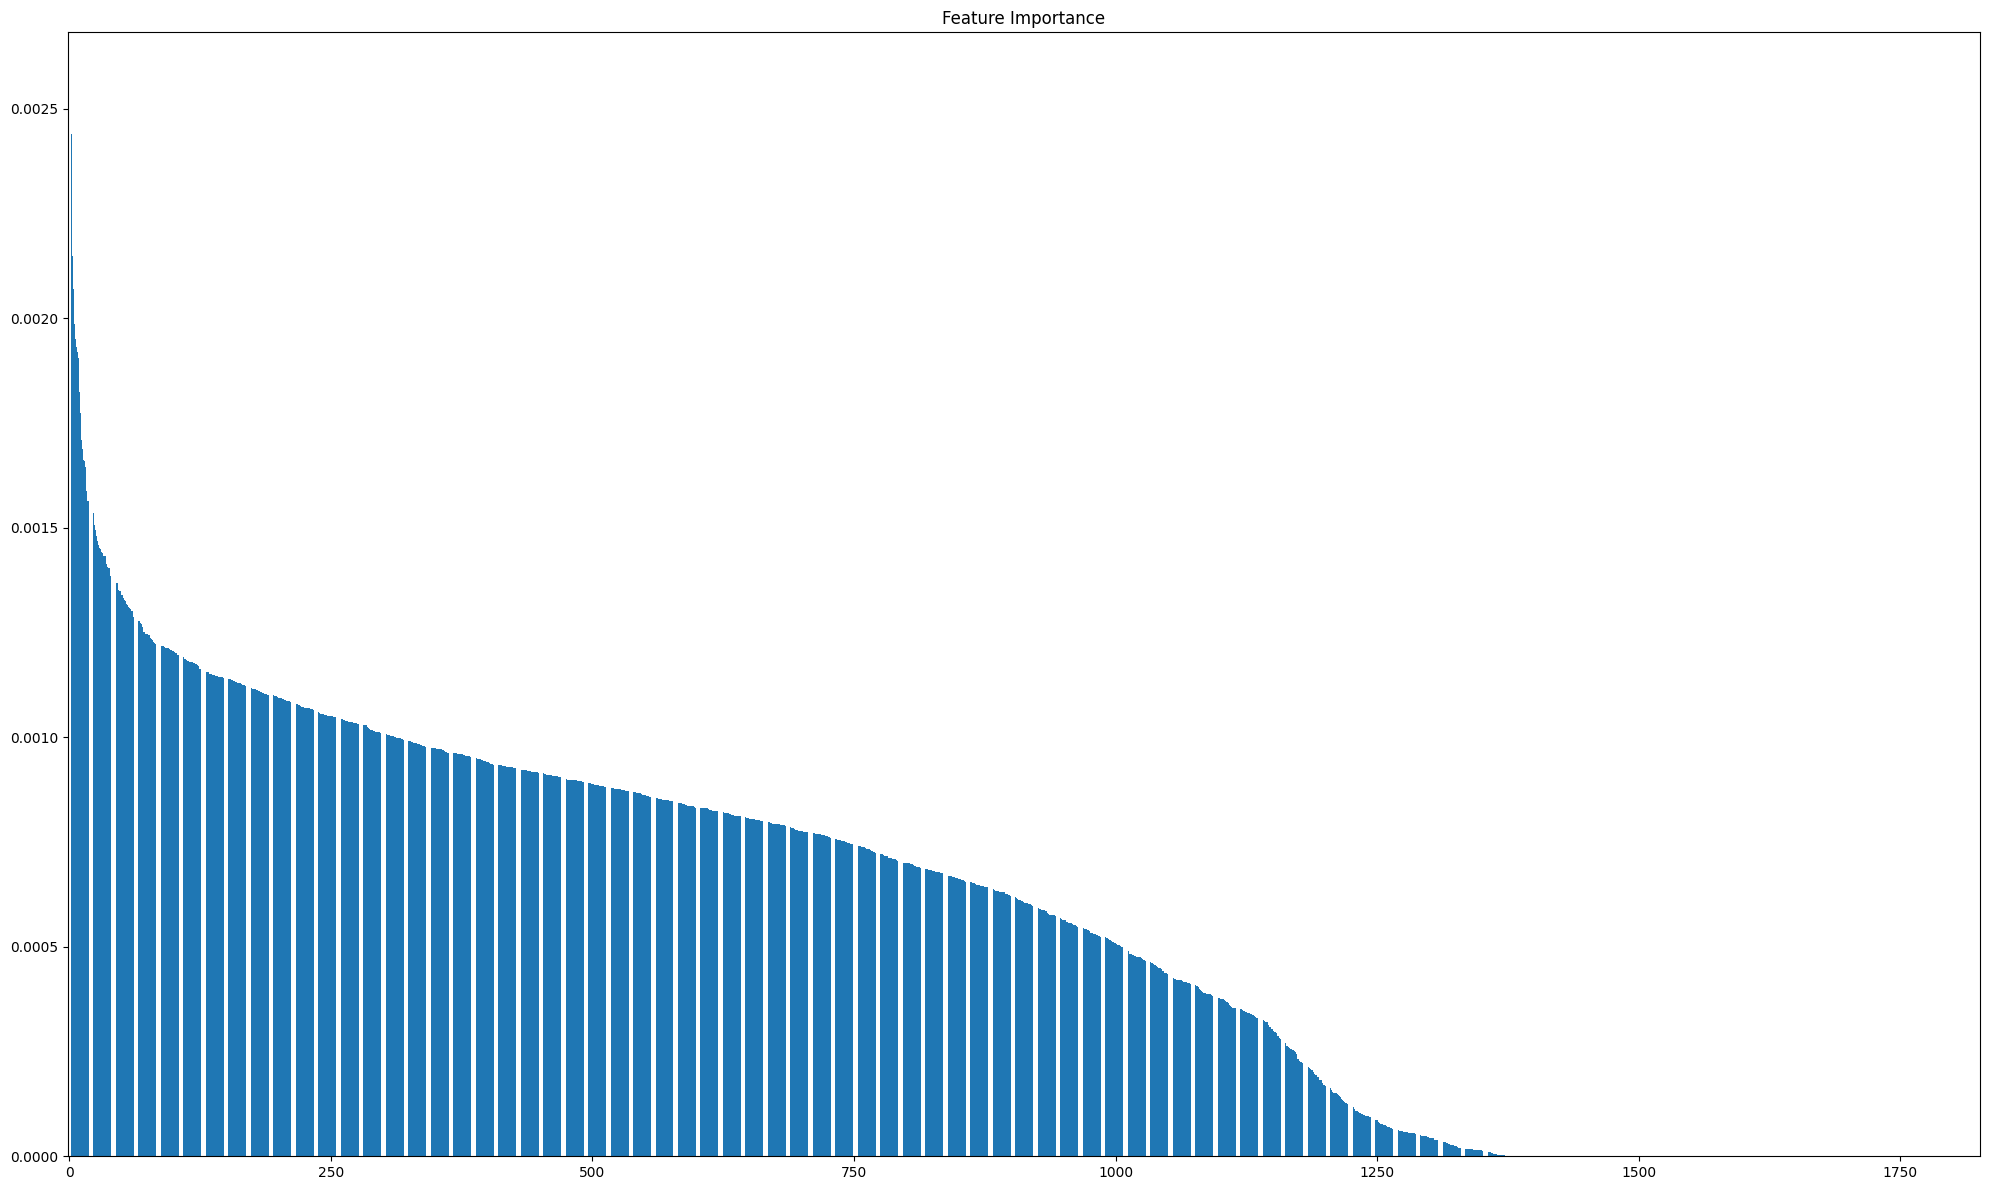

In [16]:
plt.figure(figsize=(20, 12))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

In [17]:
# feature selection by setting a threshold

sfm = SelectFromModel(forest, threshold=0.000001, prefit=True)
X_selected = sfm.transform(X_train)
print(f'Number of features that meet this threshold criterion: {X_selected.shape[1]}')

selected = []
for f in range(X_selected.shape[1]):
    selected.append(feat_labels[indices[f]])

selected = selected + ['SMILES', 'Bioavailability', 'Bioavailability_class']
df_train = df_train.drop(columns=[col for col in df_train.columns if col not in selected])
df_train

Number of features that meet this threshold criterion: 1373


,SMILES,Bioavailability,Bioavailability_class,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCOC(=O)O[C@]1(C(=O)OCCl)CC[C@H]2[C@@H]3CCC4=C...,0,0,25.041640869364688,20.57281274082361,0.0,0.0,39.95664429799973,2.682353523552323,5.300748543411457,...,10.897128138837616,83.82474512124803,466.1758310120008,7.399616365269854,2580.0,68.0,180.0,227.0,12.32638888888889,6.979166666666665
1,Clc1ccc([C@H](Cn2ccnc2)OCc2csc3c(Cl)cccc23)c(C...,0,0,21.33917226222056,17.474154305386996,0.0,0.0,35.11677257057164,2.4378875382949183,4.795307625883561,...,10.17888193964875,77.81255531836474,435.9970671400004,10.380882550952391,1886.0,40.0,144.0,170.0,7.75,5.888888888888888
2,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,0,0,31.646473381404583,21.395324325699956,0.0,1.0,51.18687544142878,2.4460183697820717,4.875513754592934,...,10.537919225261291,90.65415317010971,580.1347322120008,8.789920185030315,6645.0,59.0,212.0,244.0,12.034722222222221,8.569444444444445
3,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,0,0,19.621501331170048,16.81140333016038,0.0,0.0,33.83174028004556,2.5791501076641987,5.142418792854637,...,10.369640025590375,73.4765216909693,344.1080262240005,8.193048243428583,1225.0,44.0,134.0,164.0,6.118055555555555,5.611111111111112
4,CCCCC(F)(F)[C@@]1(O)CC[C@H]2[C@@H](CC(=O)[C@@H...,0,0,20.387860451190146,16.59906230716484,1.0,0.0,32.77753950733269,2.5335162757395566,5.006932942862184,...,10.251570692406156,76.39818081779654,390.2217805640008,6.613928484135607,2140.0,42.0,136.0,158.0,10.930555555555557,6.020833333333332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,Cn1cnc([N+](=O)[O-])c1Sc1ncnc2[nH]cnc12,60,1,14.975211231541632,13.540324522926008,0.0,0.0,24.469012111986906,2.4411864703101127,4.779116679820422,...,9.878836189094999,68.36767794779092,277.0381934640002,10.655315133230776,676.0,28.0,102.0,122.0,6.027777777777778,4.1388888888888875
1713,Clc1cccc(Cl)c1NC1=NCCN1,95,2,10.74450108824081,9.870405139419825,0.0,3.0,17.881593534346727,2.3355904555359253,4.6510274001822545,...,9.34233308143468,58.49684194471431,229.01735264799999,9.957276202086955,301.0,17.0,70.0,80.0,4.444444444444445,3.138888888888889
1714,N=C(N)N=C(O)Cc1c(Cl)cccc1Cl,81,2,11.072670487464345,10.31114816584457,0.0,3.0,17.507309530195403,2.3184381352943872,4.636876270588775,...,9.306650052113591,46.323687456378245,245.012267268,10.208844469499999,384.0,19.0,70.0,77.0,6.805555555555555,3.388888888888889
1715,O=P([O-])([O-])C(Cl)(Cl)P(=O)(O)O,1,0,8.152948101667098,8.723359803431793,4.0,0.0,10.363081100704111,2.4494897427831783,4.898979485566356,...,9.682903223616842,42.37428605499219,241.87146356382001,18.605497197216923,136.0,18.0,56.0,64.0,8.1875,2.125


## Plots

Occurrence of bioavailability classes: 
 0    638
2    607
1    472
Name: Bioavailability_class, dtype: int64 



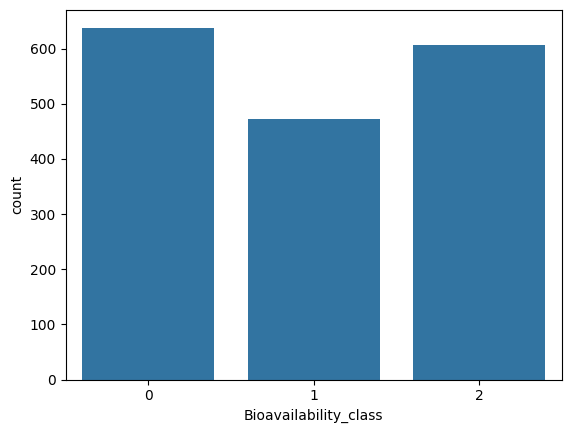

In [18]:
# Label counts

print(f'Occurrence of bioavailability classes: \n {df_train["Bioavailability_class"].value_counts()} \n')

sns.countplot(data=df_train, x='Bioavailability_class')
plt.show()

In [19]:
# PCA

X = df_train.iloc[:, 3:].values

scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

pca.explained_variance_ratio_*100

array([2.63256949e+01, 8.25416026e+00, 6.31050670e+00, ...,
       2.58407565e-31, 2.58407565e-31, 2.58407565e-31])

Text(0, 0.5, 'Explained variance')

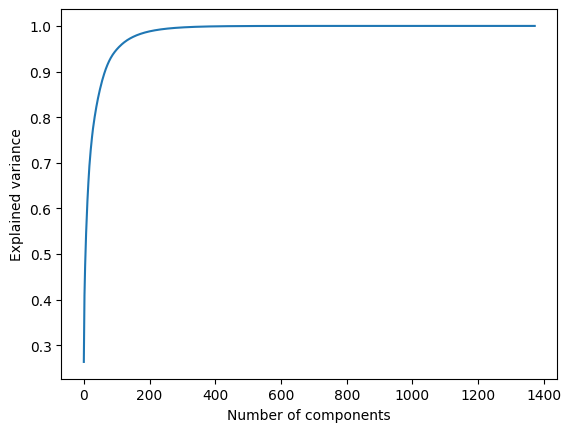

In [20]:
# PCA explained variance

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

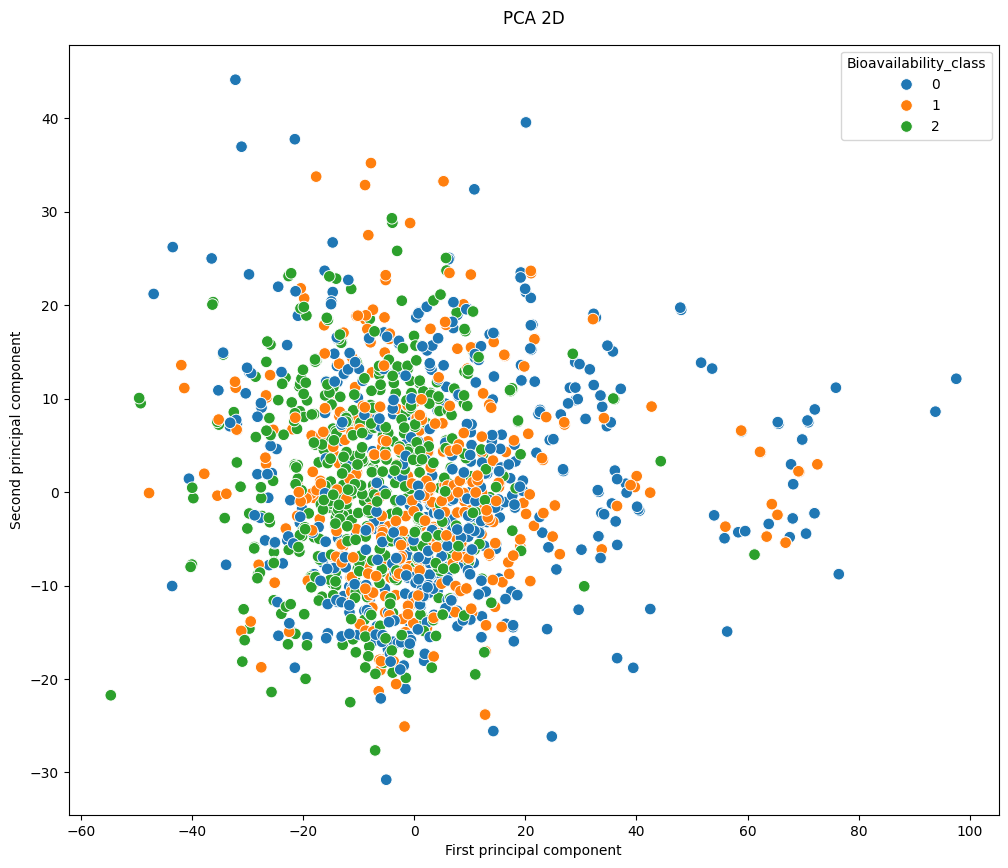

In [31]:
# PCA 2 components
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=70, hue=df_train.Bioavailability_class)
plt.title('PCA 2D', pad=15)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

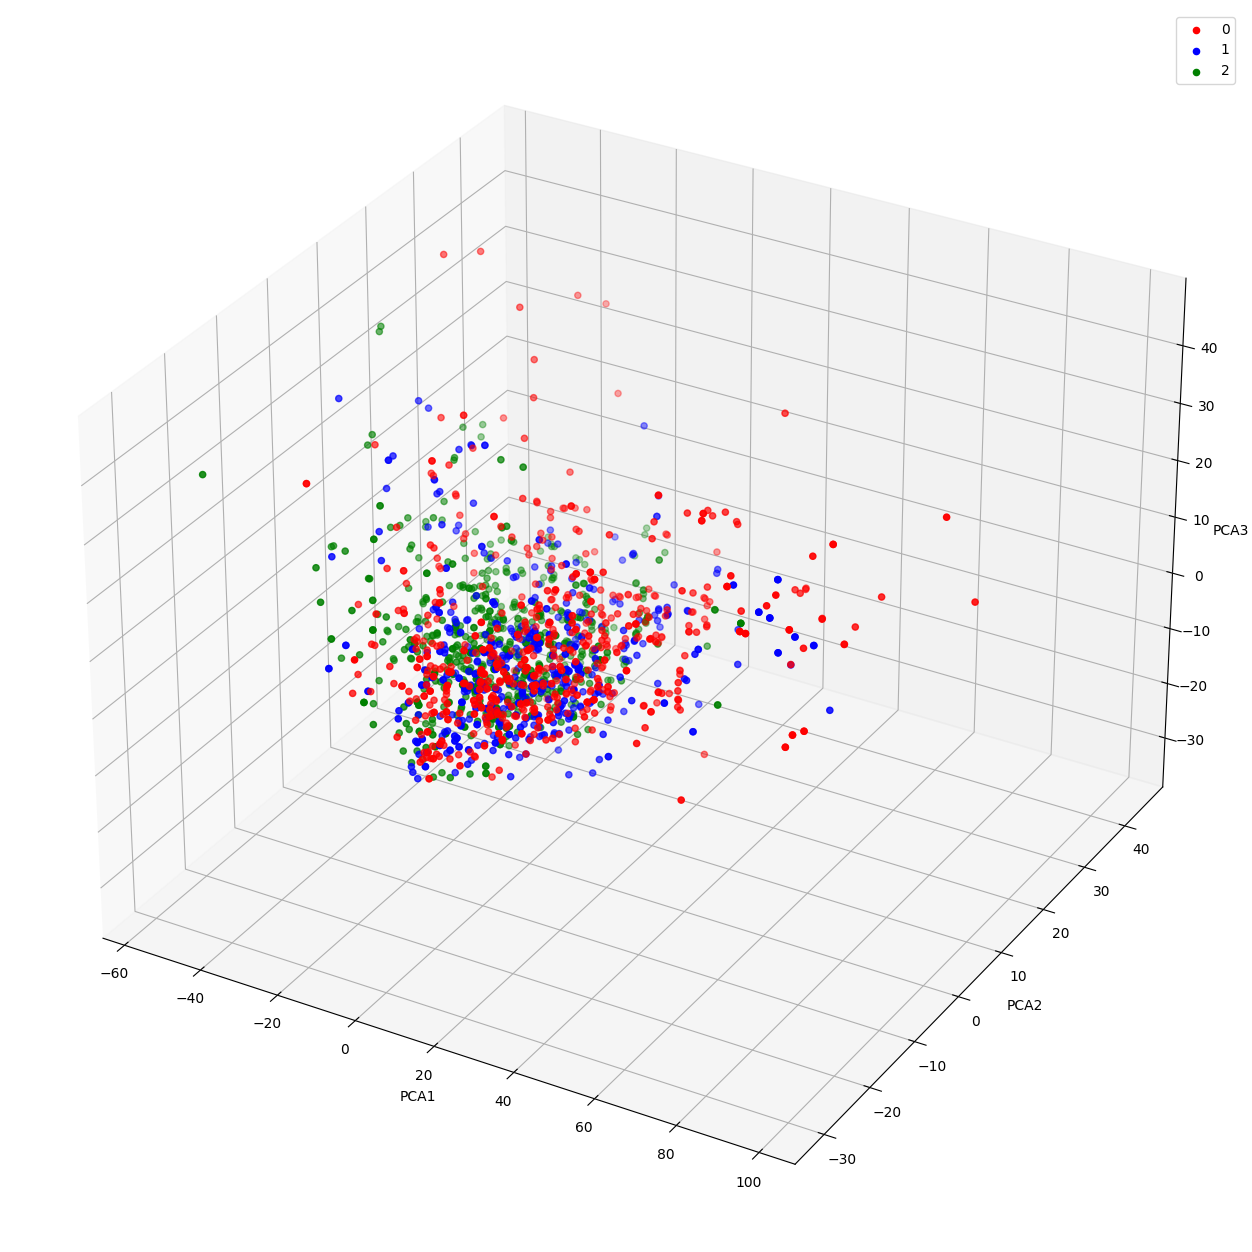

In [29]:
# PCA 3 components

df_pca = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'PCA3': X_pca[:,2]})
df_pca['Label'] = df_train['Bioavailability_class']

colors = {
    '0': 'red',
    '1': 'blue',
    '2': 'green'}

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

for label, color in colors.items():
    ax.scatter(df_pca.loc[df_pca['Label'] == label, 'PCA1'],
               df_pca.loc[df_pca['Label'] == label, 'PCA2'],
               df_pca.loc[df_pca['Label'] == label, 'PCA3'],
               c=color, label=label)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

ax.legend()

plt.show()

<Axes: ylabel='Bioavailability_class'>

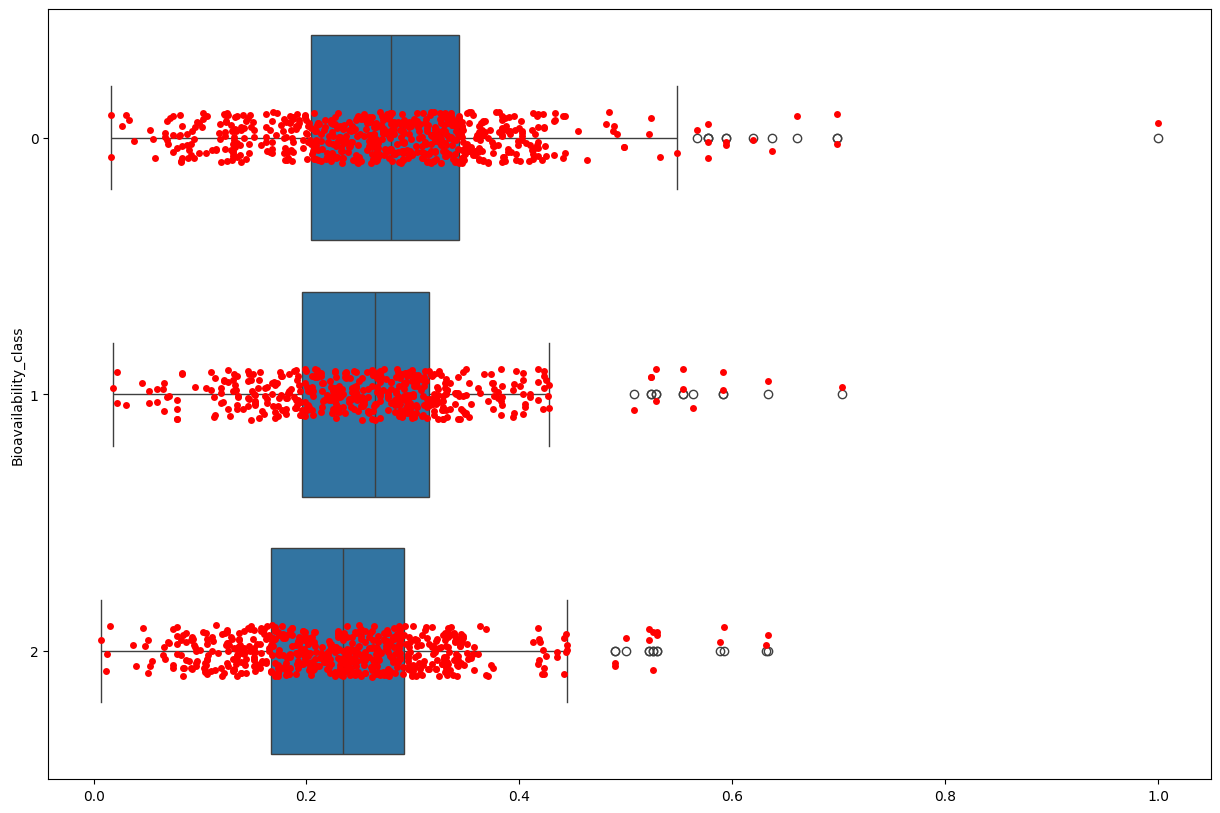

In [32]:
# similarity analysis, taking the first sample of the dataset as a reference

ms = [Chem.MolFromSmiles(x) for x in df_train['SMILES'].to_list()] # make a list of mols
fps = [FingerprintMols.FingerprintMol(x, minPath=1, maxPath=7, fpSize=2048,
                                      bitsPerHash=2, useHs=True, tgtDensity=0.0,
                                      minSize=128) for x in ms] # make a list of fingerprints

sim = []
for n in range(len(fps)):
    s = DataStructs.TanimotoSimilarity(fps[0], fps[n])
    sim.append(s)

df_sim = pd.DataFrame(sim)

fig = plt.figure(figsize=(15, 10))
sns.boxplot(x=sim, y=df_train["Bioavailability_class"])
sns.stripplot(x=sim, y=df_train["Bioavailability_class"], color='red')

# Model Selection

In [33]:
X = df_train.iloc[:, 3:].values
y = df_train['Bioavailability_class'].values

In [36]:
scaler = preprocessing.MinMaxScaler()  # Apply Min-Max scaling to selected columns
scaler.fit(X)
X_scaled = scaler.transform(X)

## Grid Search

In [38]:
# grid search of a SVM classifier by adopting a One vs. Rest approach
model_to_set = OneVsRestClassifier(SVC())
param_grid = {'estimator__C': [0.1, 1, 10, 100, 1000],
                'estimator__kernel': ['linear', 'rbf', 'poly'],
                'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
print('One vs Rest with SVC tuning parameters:')
model_tuning = GridSearchCV(model_to_set, param_grid, cv=3, refit=True, verbose=3)
model_tuning.fit(X_scaled, y)
print(f'One vs. Rest with SVC best score: {model_tuning.best_score_} \n')
print(f'One vs Rest with SVC best params: {model_tuning.best_params_} \n')

One vs Rest with SVC tuning parameters:
Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV 1/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=linear;, score=0.620 total time=   3.0s
[CV 2/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=linear;, score=0.528 total time=   2.1s
[CV 3/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=linear;, score=0.556 total time=   2.5s
[CV 1/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf;, score=0.625 total time=   4.7s
[CV 2/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf;, score=0.516 total time=   4.3s
[CV 3/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf;, score=0.633 total time=   5.3s
[CV 1/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=poly;, score=0.740 total time=   3.2s
[CV 2/3] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=poly;, score=0.596 total time=   2.7s
[CV 3/3] END estimator__C=0.1, estimato

In [ ]:
# grid search of a Random Forest classifier
model_to_set = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}
print('RFC tuning parameters:')
model_tuning = GridSearchCV(model_to_set, param_grid, cv=3, refit=True, verbose=3)
model_tuning.fit(X_scaled, y)
print(f'RFC best score: {model_tuning.best_score_} \n')
print(f'RFC best params: {model_tuning.best_params_} \n')

In [43]:
print(f'RFC best score: {model_tuning.best_score_} \n')
print(f'RFC best params: {model_tuning.best_params_} \n')

RFC best score: 0.7565231452666007 

RFC best params: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42} 



# Model Assessment

In [45]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=5,
                               min_samples_leaf=1, max_features='auto', bootstrap=False,
                               random_state=42)
model.fit(X_scaled, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_features='auto',
                       min_samples_split=5, random_state=42)

In [46]:
df_test = pd.read_csv('/content/test_set.csv')
df_test = df_test.drop(columns=[col for col in df_test.columns if col not in selected])
df_test

,SMILES,Bioavailability,Bioavailability_class,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]...,0.0,0,28.754989,23.660827,0.0,5.0,47.373524,2.474883,4.949765,...,10.582561,74.881895,552.311892,6.735511,4560.0,67.0,194.0,230.0,15.666667,8.611111
1,C=CC[N@@+]12CC[C@]34c5ccccc5N5/C=C6/[C@@H]7C[C...,0.0,0,41.448249,28.387504,0.0,2.0,68.136959,2.790534,5.415390,...,11.562867,109.064808,666.392280,6.663923,7363.0,126.0,316.0,420.0,12.527778,10.666667
2,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CSc3cc...,0.0,0,21.586461,16.990294,1.0,0.0,35.446415,2.571426,5.142851,...,10.453370,63.776322,423.055877,9.401242,2292.0,41.0,144.0,169.0,10.111111,6.194444
3,CO/N=C(/C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...,0.0,0,28.754989,22.911571,2.0,0.0,46.360396,2.575082,5.149065,...,10.721967,89.984830,584.027631,10.246099,4854.0,57.0,196.0,234.0,13.916667,8.111111
4,CN1C[C@@H](C(=O)N[C@@]2(C)O[C@]3(O)[C@H]4CCCN4...,1.0,0,35.440625,26.286287,0.0,1.0,56.940377,2.669553,5.185190,...,11.147080,99.273521,583.279469,7.290993,6191.0,88.0,258.0,326.0,12.652778,8.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,[H]/N=C(/N)N/C(=N/[H])N(C)C,52.0,1,7.358797,7.884672,0.0,5.0,12.617971,2.169236,4.338473,...,8.548886,39.497463,129.101445,6.455072,168.0,12.0,44.0,46.0,6.083333,2.777778
171,COC1C=COC2(C)Oc3c(C)c(O)c4c(O)c(c5c(c4c3C2=O)N...,20.0,0,47.707791,33.594676,0.0,1.0,76.496594,2.670505,5.236782,...,11.262835,117.325136,846.441509,6.881638,15031.0,121.0,334.0,408.0,25.041667,13.138889
172,CC(C)C(=O)Nc1ccc([N+](=O)[O-])c(C(F)(F)F)c1,90.0,2,14.275804,13.128940,0.0,0.0,21.566428,2.416610,4.833220,...,9.798071,52.165203,276.072177,9.202406,706.0,28.0,94.0,106.0,9.729167,4.083333
173,CN1C2CCC1CC(OC(=O)c1cn(C)c3ccccc13)C2,66.0,1,17.763198,14.701784,0.0,1.0,29.215654,2.478209,4.811903,...,10.166659,72.992174,298.168128,6.776548,1058.0,36.0,124.0,151.0,6.500000,4.666667


In [47]:
X_test = df_test.iloc[:, 3:].values
y_test = df_test['Bioavailability_class'].values

X_test_scaled = scaler.transform(X_test)

Test accuracy: 0.9970879440885265 

Test precision: 0.9968441684284707 

Test recall: 0.9969401241634789 

Test f1 score: 0.9968889193291485


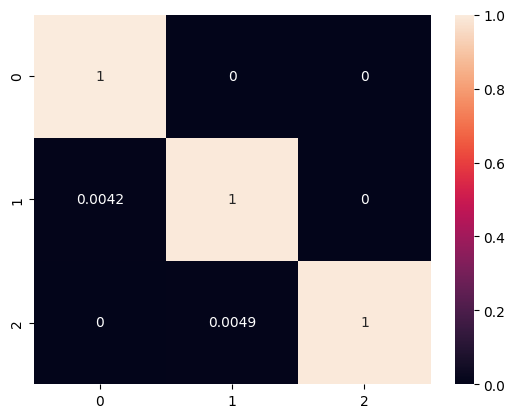

In [71]:
y_pred_train = model.predict(X_scaled)
print(f'Test accuracy: {accuracy_score(y, y_pred_train)} \n')
print(f'Test precision: {precision_score(y, y_pred_train, average="macro")} \n')
print(f'Test recall: {recall_score(y, y_pred_train, average="macro")} \n')
print(f'Test f1 score: {f1_score(y_train, y_pred_train, average="macro")}')

cf_ma = confusion_matrix(y, y_pred_train, normalize='true')
sns.heatmap(cf_ma, annot=True)
plt.show()

Test accuracy: 0.8285714285714286 

Test precision: 0.8274356071723058 

Test recall: 0.8235896702877835 

Test f1 score: 0.8236517490248834


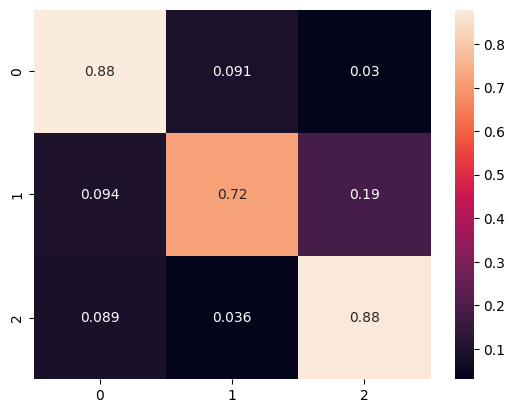

In [69]:
y_pred_test = model.predict(X_test_scaled).astype(str).astype(int)
print(f'Test accuracy: {accuracy_score(y_test, y_pred_test)} \n')
print(f'Test precision: {precision_score(y_test, y_pred_test, average="macro")} \n')
print(f'Test recall: {recall_score(y_test, y_pred_test, average="macro")} \n')
print(f'Test f1 score: {f1_score(y_test, y_pred_test, average="macro")}')

cf_ma = confusion_matrix(y_test, y_pred_test, normalize='true')
sns.heatmap(cf_ma, annot=True)
plt.show()